# **Reinforcement Learning Project - Inventory beer game**

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

### **Setup**

In [193]:
# Supply Chain and its agents
supply_chain = {'level 0': 'Customer',
                'level 1': 'Retailer',
                'level 2': 'Distributor'}

agents = [supply_chain[i] for i in list(supply_chain.keys())[1:]]


# All possible coded inventory positions of agents and the respective state pairs (5 states with 25 state pairs)
states = np.arange(start=1, stop=6)
state_pairs = [(i, j) for i in states for j in states]

# y-value in ordering rule x+y with x equal to the demand from the downstream agent and the respective action pairs (4 actions with 16 action pairs)
actions = np.arange(stop=4)
action_pairs = [(i, j) for i in actions for j in actions]


# Initial matrix with Q-values (minimization -> high values)
Q_values = np.full(shape=(len(state_pairs), len(action_pairs)), fill_value=1000)
df_Q_values = pd.DataFrame(data=Q_values, index=state_pairs, columns=action_pairs)
display(df_Q_values.head())

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
"(1, 1)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 2)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 3)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 4)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 5)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


In [194]:
# Define parameters
iteration = 1
max_iteration = 1
T = 15 #smaller
gamma = 1 #smaller
alpha = 0.17
sigma = 0.05
proba_exploitation = 0.02
start_exploitation = proba_exploitation
truck_load = 4
train_load = 4

# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]
G = [0 for i in range(T)]
q = [0 for i in range(T)]
Q = [1] + [0 for i in range(max_iteration)]

**Meaning of the variables**
- S: (start-)inventory positions/states per agent and time step t
- CS: coded states per agent and time step t
- O: ordering size per agent and time step t
- D: distribution amount per agent and time step t
- x: demand from downstream level per agent and time step t
- y: action per agent and time step t
- r: reward per agent and time step t
- R: reward of the supply chain per time step t
- Return G: total discounted rewards per time step t
- q: measure the decrease of the Q-value per time step t
- Q: measure the mean decrease of Q-values per episode to indicate convergence

In [195]:
# helperfunctions
# function to convert real states to coded states
def coded_state(inventory):
    if inventory < -5:
        return 1
    elif inventory < 0:
        return 2
    elif inventory < 5:
        return 3
    elif inventory < 12:
        return 4
    else:
        return 5


# function to view episodes
def fun_episode(S, CS, D, O, x, y, r, head=True):
    time_steps = ['t='+str(i) for i in np.arange(start=1, stop=T+2)]

    df = pd.DataFrame({'Inventory/States S': [tuple(i) for i in S],
                   'Coded states CS': [tuple(i) for i in CS],
                   'Demand x': [tuple(i) for i in x],
                   'Distribution amount D': [tuple(i) for i in D],
                   'Action y': [tuple(i) for i in y],
                   'Ordering size': [tuple(i) for i in O],
                   'Costs r': [tuple(i) for i in r]},
                   index=time_steps)
    df.index.name = 'Time'
    if head == True:
        return display(df.head())
    else: return display(df)


# function to define the starting states of the supply chain
def fun_start_state(how='value', inv=12):
    # select own start values for all agents
    if how == 'value':
        for agent in range(len(agents)):
            S[0][agent] = inv
            CS[0][agent] = coded_state(S[0][agent])
    
    # each episode has a change of 50% to start with high (12) or with low (-2) inventory for all agents
    elif how == 'high/low':
        starting_state = random.choices(population=['high', 'low'], weights=[0.5, 0.5])[0]
        if starting_state == 'high':
            for agent in range(len(agents)):
                S[0][agent] = 12
                CS[0][agent] = coded_state(S[0][agent])
        else:
            for agent in range(len(agents)):
                S[0][agent] = -2
                CS[0][agent] = coded_state(S[0][agent])

    # random starting positions (-10 to 16) of agents for each episode
    elif how == 'random':
        for agent in range(len(agents)):
            S[0][agent] = random.choices(np.arange(start=-10, stop=16))[0]
            CS[0][agent] = coded_state(S[0][agent])


# function to measure the Q-value decrease
def fun_q_decrease(alpha, q_value, G):
    new_q_value = (1-alpha) * q_value + alpha * G
    decrease = new_q_value / q_value
    return new_q_value, decrease

# function to visualize the Q-vlaue decrease
def plot_q_decrease(Q):
    plt.figure(figsize=(12,4))
    plt.plot(Q)
    plt.xlim(0, max_iteration)
    plt.ylim(0, 1.1)
    plt.xlabel('episode/iteration')
    plt.ylabel('Q-value decrease')
    plt.title('Q-value decrease per episode', size=18)
    return plt.show()

In [196]:
# Three possible options to set starting states
fun_start_state(how='value', inv=10)
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

fun_start_state(how='high/low')
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

fun_start_state(how='random')
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

Inventory state S: [[10, 10], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
Coded state S: [[4, 4], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

Inventory state S: [[12, 12], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
Coded state S: [[5, 5], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

Inventory state S: [[3, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
Coded state S: [[3, 3], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]



-------------------episode 1------------------
Exploitation probability: 0.02

-----------------time step t=0----------------
State S: (12, 12) and coded state CS: (5, 5)
Lead time lag of 0 time steps

------------------Retailer------------------
Demand x from downstream (Customer) at t-1: 3
Distribution size D: 3
Backlog size: 0
Best action y*: 0
Action y: 0
Ordering size O: 3
------------------Distributor------------------
Demand x from downstream (Retailer) at t-1: 0
Distribution size D: 0
Backlog size: 0
Best action y*: 0
Action y: 3
Ordering size O: 3

UPDATING STATES AND CALCULATING COSTS PER AGENT
------------------Retailer------------------
Inventory after receiving truck load +4 (demand of t-2) and order +0: 13
Costs r: 13

------------------Distributor------------------
Inventory after receiving order +3 of t-1: 15
Costs r: 15

Supply Chain costs R in state (12, 12) with action (0, 3) at t=0: 28



-----------------time step t=1----------------
State S: (13, 15) and coded sta

,Inventory/States S,Coded states CS,Demand x,Distribution amount D,Action y,Ordering size,Costs r
Time,,,,,,,
t=1,"(12, 12)","(5, 5)","(3, 0)","(3, 0)","(0, 3)","(3, 3)","(13, 15)"
t=2,"(13, 15)","(5, 5)","(2, 3)","(2, 3)","(2, 3)","(4, 6)","(18, 18)"
t=3,"(18, 18)","(5, 5)","(9, 4)","(9, 4)","(2, 2)","(11, 6)","(13, 20)"
t=4,"(13, 20)","(5, 5)","(9, 11)","(9, 11)","(2, 3)","(11, 14)","(15, 23)"
t=5,"(15, 23)","(5, 5)","(5, 11)","(5, 11)","(0, 3)","(5, 14)","(21, 26)"
t=6,"(21, 26)","(5, 5)","(5, 5)","(5, 5)","(0, 3)","(5, 8)","(21, 29)"
t=7,"(21, 29)","(5, 5)","(0, 5)","(0, 5)","(1, 0)","(1, 5)","(26, 29)"
t=8,"(26, 29)","(5, 5)","(4, 1)","(4, 1)","(0, 3)","(4, 4)","(23, 32)"
t=9,"(23, 32)","(5, 5)","(1, 4)","(1, 4)","(2, 3)","(3, 7)","(26, 35)"


-----Rewards and Total discounted returns-----
Immediate reward R in t=14: 77
Immediate reward R in t=13: 84
Immediate reward R in t=12: 71
Immediate reward R in t=11: 72
Immediate reward R in t=10: 60
Immediate reward R in t=9: 56
Immediate reward R in t=8: 61
Immediate reward R in t=7: 55
Immediate reward R in t=6: 55
Immediate reward R in t=5: 50
Immediate reward R in t=4: 47
Immediate reward R in t=3: 38
Immediate reward R in t=2: 33
Immediate reward R in t=1: 36
Immediate reward R in t=0: 28

Total discounted rewards (Return G): 
[823, 795, 759, 726, 688, 641, 591, 536, 481, 420, 364, 304, 232, 161, 77.0]

---------------UPDATING Q-VALUES--------------
t=0: state: (5, 5), action: (0, 3), old Q-value: 1000, return: 823
New Q-value: 969.91

t=1: state: (5, 5), action: (2, 3), old Q-value: 1000, return: 795
New Q-value: 965.15

t=2: state: (5, 5), action: (2, 2), old Q-value: 1000, return: 759
New Q-value: 959.03

t=3: state: (5, 5), action: (2, 3), old Q-value: 965.15, return: 726
N

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
"(1, 1)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 2)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 3)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 4)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 5)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 1)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 2)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 3)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 4)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 5)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00


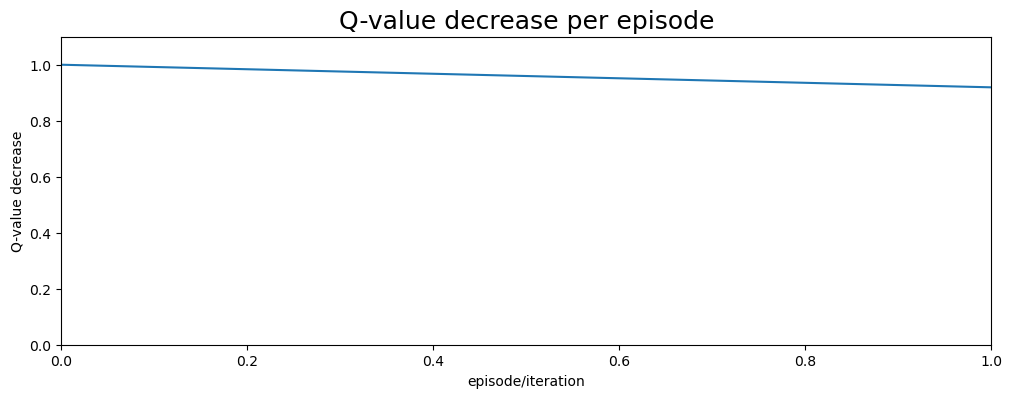

In [197]:
#%%capture
# Main function

while iteration <= max_iteration:
    # if iteration in [1, 10, 100, 1000, 10000, 25000, 50000, 75000, 100000, max_iteration]:
    #     print('iteration {}'.format(iteration))

    print('-------------------episode {}------------------'.format(iteration))
    print('Exploitation probability: {}\n'.format(proba_exploitation))
    t=0

    # random starting position of agents for each episode
    fun_start_state(how='value', inv=12) #option 1: ('value', inv=12); option 2: 'high/low'; option 3: 'random'

    while t < T:
        print('-----------------time step t={}----------------'.format(t))

        # view state and coded state
        state = tuple(S[t])
        c_state = tuple(CS[t])
        print('State S: {} and coded state CS: {}'.format(state, c_state))

        # define random lead time lag (between 0 and 2)
        lag = random.choices(population=[0, 1, 2], weights=[0.6, 0.3, 0.1])[0]
        print('Lead time lag of {} time steps\n'.format(lag))

        for agent in range(len(agents)):
            level = supply_chain['level ' + str(agent+1)]
            print('------------------{}------------------'.format(level))

        # step 1: receive the new demand of the downstream agent
            if level == 'Retailer':
                x[t][agent] = np.random.randint(low=0, high=15)
            else:
                x[t][agent] = O[t-1][agent-1]
            
            # Add negative inventory (=demand of previous time steps) to the new demand
            inventory = S[t][agent]
            if inventory >= 0:
                print('Demand x from downstream ({}) at t-1: {}'.format(supply_chain['level ' + str(agent)], x[t][agent]))
            else:
                print('Demand x from downstream ({}) at t-1 + demand of previous time steps:'.format(supply_chain['level ' + str(agent)]))
                print(    '{} + {} = {}'.format(x[t][agent], np.abs(inventory), x[t][agent] + np.abs(inventory)))
                x[t][agent] += np.abs(inventory)

        # step 2: fulfill order of downstream agent from onhand inventory and calculate possible backlog costs
            if inventory >= 0:
                D[t][agent] = min(x[t][agent], inventory) #distribution quantity
                print('Distribution size D: {}'.format(D[t][agent]))
            else:
                D[t][agent] = min(x[t][agent], D[min(0, t-1)][agent+1]) #negative inventory is demand of previous time steps and still needs to be complied
                print('Distribution size D (delivery of upstream agent in t-1): {}'.format(D[t][agent]))
            backlog = x[t][agent] - D[t][agent] #penalty/backlog costs (previous backlogs included in demand if inventory is negative)
            print('Backlog size: {}'.format(backlog))

        # step 3: placing order for stock replenishment
            # define best action for agent and select it with initially very small probability (first exploration and mostly random choices)
            best_action = df_Q_values.iloc[df_Q_values.index.get_loc(tuple(CS[t]))].idxmin()[agent]
            print('Best action y*: {}'.format(best_action))

            y[t][agent] = random.choices([best_action] + list(actions), weights=[proba_exploitation] + list(np.repeat((1 - proba_exploitation) / len(actions), len(actions))))[0]
            print('Action y: {}'.format(y[t][agent]))

            if inventory >= 0:
                O[t][agent] = x[t][agent] + y[t][agent] #O[t+lag] !!
            else: O[t][agent] = x[t][agent] + inventory + y[t][agent] #subtract negative inventory (demand of previous time steps) again - has been ordered already
            print('Ordering size O: {}\n'.format(O[t][agent]))

        # step 4: previous orders are received from the upstream agent (update states for t+1)
        print('UPDATING STATES AND CALCULATING COSTS PER AGENT')
        for agent in range(len(agents)):
            level = supply_chain['level ' + str(agent+1)]
            print('------------------{}------------------'.format(level))

            inventory = S[t][agent] - x[t][agent]
            #if level == 'Retailer': lag = 0 #retailer's lead time to customer is zero
            if level != agents[-1]:
                if t == 0:
                    S[t+1][agent] = inventory + truck_load + D[t][agent+1] #truck load represets order of t-2
                    print('Inventory {} after receiving truck load +{} (demand of t-2) and order +{}: {}'.format(inventory, truck_load, D[t][agent+1], S[t+1][agent]))
                elif t == 1:
                    S[t+1][agent] = inventory + train_load + D[t][agent+1] #train load represets order of t-1
                    print('Inventory {} after receiving train load +{} (demand of t-1) and order +{}: {}'.format(inventory, train_load, D[t][agent+1], S[t+1][agent]))
                else:
                    S[t+1][agent] = inventory + D[t][agent+1]
                    print('Inventory {} after receiving order +{} of t-1: {}'.format(inventory, D[t][agent+1], S[t+1][agent]))
            else:
                S[t+1][agent] = inventory + O[t][agent] #last agent in supply chain has no supplier (delivers from warehouse)
                print('Inventory {} receiving order +{} of t-1: {}'.format(inventory, O[t][agent], S[t+1][agent]))
            
            # update coded states
            CS[t+1][agent] = coded_state(S[t+1][agent])

            # calculate agent's costs (onhand inventory holding costs + penalty costs)
            r[t][agent] = 1 * max(S[t+1][agent], 0) + 2 * (x[t][agent] - D[t][agent]) #backlog
            print('Costs r: {}\n'.format(r[t][agent]))

        # calculate the total supply chain costs in t
        action = tuple(y[t])
        R[t] = np.sum(r[t])
        print('Supply Chain costs R in state {} with action {} at t={}: {}'.format(state, action, t, R[t]))            
        
        # increase time step t
        t += 1
        print('\n\n')

    # view last episode
    fun_episode(S, CS, D, O, x, y, r, head=False)

    # Loop from T to t=0 to calculate immediate rewards and returns
    print('-----Rewards and Total discounted returns-----')
    for t in np.arange(start=0, stop=T)[::-1]:
        # view immediate reward of each visited state-action-pair
        print('Immediate reward R in t={}: {}'.format(t, R[t]))

        # calculate the return G: total discounted rewards
        G[t] = R[t] + np.sum(R[t+1:] * np.array([gamma**i for i in np.arange(start=1, stop=T-t)]))
    
    # view returns of all state-action-pairs
    print('\nTotal discounted rewards (Return G): \n{}\n'.format(G))

    # update all visited Q-values
    print('---------------UPDATING Q-VALUES--------------')
    for t in range(T):
        state = tuple(CS[t])
        action = tuple(y[t])

        # get current Q-value
        q_value = df_Q_values.iloc[df_Q_values.index.get_loc(state), df_Q_values.columns.get_loc(action)]
        print('t={}: state: {}, action: {}, old Q-value: {}, return: {}'.format(t, state, action, q_value, G[t]))

        # update Q-values according to equation 12 in the paper (slide 30 TD-learning script)
        df_Q_values.iloc[df_Q_values.index.get_loc(state), df_Q_values.columns.get_loc(action)] = (1-alpha) * q_value + alpha * G[t] #equal to: q_value + alpha * (G[t] - q_value)
        new_q_value, decrease = fun_q_decrease(alpha, q_value, G[t])
        q[t] = decrease
        print('New Q-value: {}\n'.format(new_q_value))

    # calculate mean Q-value decrease of current episode
    Q[iteration] = np.mean(q)

    # Check if the convergence criterion has been reached
    if (iteration > 100) & (np.mean(Q[iteration-5:iteration]) < sigma):
        print('Convergence!')
        break

    # increase exploitation probability linearly
    proba_exploitation += (0.95 - start_exploitation) / max_iteration
    print('\n\n')

    # start with next iteration
    iteration += 1

# round dataframe with Q-values
df_Q_values = np.round(df_Q_values, 2)

# view new Q-value table
display(df_Q_values)

# plot decrease of Q-vlaues
plot_q_decrease(Q)

### **View new Q-values**

Number of state-action-pairs: 400
Percentage of updated Q-values: 2 %

Number of visits with max_iteration=1 and T=15: 15
Average amount of visits per state-action-pair: 0.0375

Last five Q-value decreases: [1]
Mean of last five Q-value decreases: 1.0


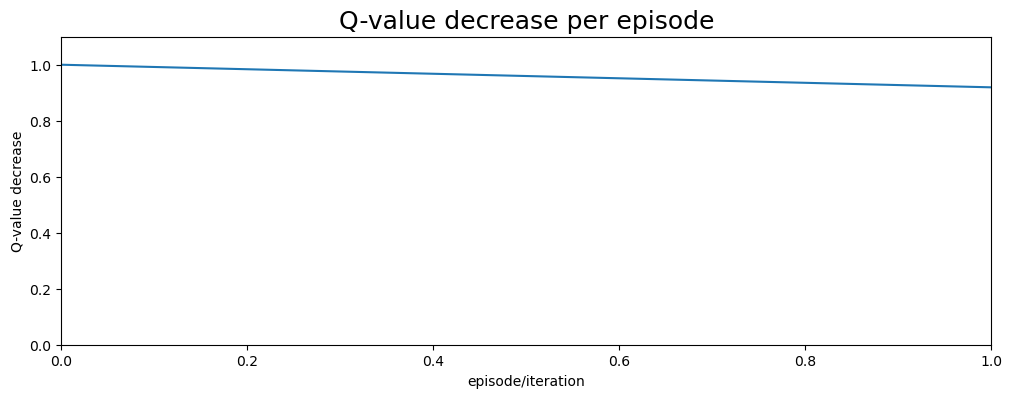

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
"(1, 1)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 2)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 3)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 4)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(1, 5)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 1)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 2)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 3)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 4)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00
"(2, 5)",1000,1000,1000,1000.00,1000.00,1000,1000.00,1000,1000.0,1000.00,1000.00,1000.00,1000,1000,1000,1000.00


In [198]:
# Percentage of updated Q-values
num_pairs = len(df_Q_values.index) * len(df_Q_values.columns)
print('Number of state-action-pairs: {}'.format(num_pairs))
print('Percentage of updated Q-values: {} %\n'.format(int(np.sum(np.sum(df_Q_values != 1000)) / num_pairs * 100)))

visits = max_iteration * T
print('Number of visits with max_iteration={} and T={}: {}'.format(max_iteration, T, visits))
print('Average amount of visits per state-action-pair: {}\n'.format(visits / num_pairs))

# plot decrease of Q-vlaues
iteration = max_iteration
print('Last five Q-value decreases: {}'.format(np.round(Q[iteration-5:iteration], 4)))
print('Mean of last five Q-value decreases: {}'.format(np.round(np.mean(Q[iteration-5:iteration]), 4)))

plot_q_decrease(Q)

df_Q_values

### **Test performance of the Reinforcement learning ordering mechanism (RLOM) on main and test problems**

In [199]:
# Main test problem
customer_demand = [15,10,8,14,9,3,13,2,13,11,3,4,6,11,15,12,15,4,12,3,13,10,15,15,3,11,1,13,10,10,0,0,8,0,14]
lead_times = [2,0,2,4,4,4,0,2,4,1,1,0,0,1,1,0,1,1,2,1,1,1,4,2,2,1,4,3,4,1,4,0,3,3,4]

# Test problem 1
customer_demand = [5,14,14,13,2,9,5,9,14,14,12,7,5,1,13,3,12,4,0,15,11,10,6,0,6,6,5,11,8,4,4,12,13,8,12]
lead_times = [2,0,2,4,4,4,0,2,4,1,1,0,0,1,1,0,1,1,2,1,1,1,4,2,2,1,4,3,4,1,4,0,3,3,4]

# Test problem 2
customer_demand = [15,10,8,14,9,3,13,2,13,11,3,4,6,11,15,12,15,4,12,3,13,10,15,15,3,11,1,13,10,10,0,0,8,0,14]
lead_times = [4,2,2,0,2,2,1,1,3,0,0,3,3,3,4,1,1,1,3,0,4,2,3,4,1,3,3,3,0,3,4,3,3,0,3]

# Test problem 3
customer_demand = [13,13,12,10,14,13,13,10,2,12,11,9,11,3,7,6,12,12,3,10,3,9,4,15,12,7,15,5,1,15,11,9,14,0,4]
lead_times = [4,2,2,0,2,2,1,1,3,0,0,3,3,3,4,1,1,1,3,0,4,2,3,4,1,3,3,3,0,3,4,3,3,0,3]

# Own test problem
customer_demand = list(np.random.randint(low=0, high=15, size=35))
lead_times = list(np.random.randint(low=0, high=4, size=35))

### **Benchmark**